<a href="https://colab.research.google.com/github/dhelms1/plant_pathology/blob/main/plant_pathology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plant Pathology Project**
---
Misdiagnosis of the many diseases impacting agricultural crops can lead to misuse of chemicals leading to the emergence of resistant pathogen strains, increased input costs, and more outbreaks with significant economic loss and environmental impacts. Current disease diagnosis based on human scouting is time-consuming and expensive, and although computer-vision based models have the promise to increase efficiency, the great variance in symptoms due to age of infected tissues, genetic variations, and light conditions within trees decreases the accuracy of detection.

In this project, we will use images of apple leaves to train a Neural Network that can correctly identify and diagnose infected/healthy leaves for one another (the disease types are listed below). The model will be evaulated based on the average of the individual AUCs of each predicted column. We will aim for above a 95% accuracy, incoporating transfer learning using the framework PyTorch.

### **Project Outcome Goals**
---
1) Accurately classify a given image from testing dataset into different diseased category or a healthy leaf.  
2) Accurately distinguish between many diseases, sometimes more than one on a single leaf.  
3) Deal with rare classes and novel symptoms.  
4) Address depth perception—angle, light, shade, physiological age of the leaf.  
5) Incorporate expert knowledge in identification, quantification, and guiding computer vision to search for relevant features during learning.

### **Disease Types (Labels)**
---
- combinations: combination of multiple disease
- healthy: no diseases present
- rust: apple rust is present on the leaf
- scab: apple scab is present on the leaf

## **Import Modules**
We will want to begin by importing the modules necessary to run the project. Along with this, we will want to setup the device to be used for training during the model. If 'cuda' is printed, we are using a GPU. Otherwise, training will be done on the CPU (at a slower rate).

*Note that if running this outside of Google Colab on a personal machine, the GPU must be Nvidia in order to use CUDA, otherwise CPU will be selected.*

In [39]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F

plt.style.use('seaborn-dark')
plt.rcParams['font.size'] = 12
palette = sns.color_palette('Paired', 10)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## **Format Images Directories**

The dataset from [Kaggle](https://www.kaggle.com/c/plant-pathology-2020-fgvc7/data) comes in one directory, with training and testing images mixed together. We will take the following steps in order to get them in the correct format to be read into the [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) method:  

1) Create a list of directory paths for both training and testing sets.  
2) Create new directories for both the train and test images.  
3) Create label subdirectories within the Train directory.  
4) Move the images from the current directory to their corresponding subdirectory.


*Note: you must mount Google Drive in order to read in images from directories.*

In [22]:
# Read in csv's containing the image_id and the disease features
test_labels = pd.read_csv('drive/My Drive/Colab Notebooks/Plant Pathology/test.csv') # df of image numbers
train_labels = pd.read_csv('drive/My Drive/Colab Notebooks/Plant Pathology/train.csv')

# Create lists for all image directory paths (1820 in each)
test_filenames = ['drive/My Drive/Colab Notebooks/Plant Pathology/images/Test_' + str(fnum) + '.jpg' for fnum in range(1821)]
train_filenames = ['drive/My Drive/Colab Notebooks/Plant Pathology/images/Train_' + str(fnum) + '.jpg' for fnum in range(1821)]

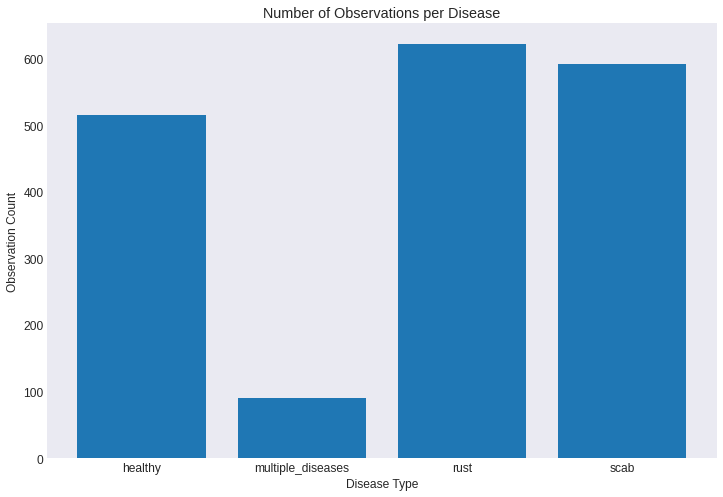

In [44]:
class_count = train_labels.drop('image_id', axis=1).sum()
plt.figure(figsize=(12,8))
plt.xticks(np.arange(len(class_count)), class_count.index)
plt.bar(class_count.index, class_count.values)
plt.title('Number of Observations per Disease')
plt.xlabel('Disease Type')
plt.ylabel('Observation Count')
plt.show();

In [3]:
# Create directories for the Train and Test images
os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Train')
os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Test')

In [20]:
# Get image names for each disease type
healthy = train_labels.image_id[train_labels.healthy == 1].values
multi = train_labels.image_id[train_labels.multiple_diseases == 1].values
rust = train_labels.image_id[train_labels.rust == 1].values
scab = train_labels.image_id[train_labels.scab == 1].values

In [13]:
# Create dictionary to map from created folder labels to original category names
cat_to_name = {'1': 'healthy',
               '2': 'multiple_diseases',
               '3': 'rust',
               '4': 'scab'}          

In [21]:
# Create label directories to move images into
os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Train/1')
os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Train/2')
os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Train/3')
os.mkdir('drive/My Drive/Colab Notebooks/Plant Pathology/images/Train/4')

In [27]:
# Move Training images from current directories to their new subdirectories
for img in healthy:
  curr_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/' + img + '.jpg'
  new_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/Train/1/' + img + '.jpg'
  Path(curr_path).rename(new_path)

for img in multi:
  curr_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/' + img + '.jpg'
  new_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/Train/2/' + img + '.jpg'
  Path(curr_path).rename(new_path)

for img in rust:
  curr_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/' + img + '.jpg'
  new_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/Train/3/' + img + '.jpg'
  Path(curr_path).rename(new_path)

for img in scab:
  curr_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/' + img + '.jpg'
  new_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/Train/4/' + img + '.jpg'
  Path(curr_path).rename(new_path)

In [36]:
# Move Testing images from current directory to new folder
for img in test_labels.image_id.values:
  curr_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/' + img + '.jpg'
  new_path = 'drive/My Drive/Colab Notebooks/Plant Pathology/images/Test/' + img + '.jpg'
  Path(curr_path).rename(new_path)

## **Read in Images**

Now that we have the images in the correct directory format, we want to read the images in using the *ImageFolder* function discussed above. We will want to perform augmentation on the training sets but not on the validation or test sets. 
